In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
import torch
import torchvision
import time

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.ops import nms
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt

from itertools import cycle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")



In [2]:
# key folders
DIR_INPUT = '../input/zindi-africa/zinda_compitation'
DIR_TRAIN = "../input/zindi-africa/zinda_compitation/Train_Images/Train_Images"
DIR_TEST = "../input/zindi-africa/zinda_compitation/Test_Images/Test_Images"

# Data loading

In [3]:
train_df = pd.read_csv("../input/zindi-africa/zinda_compitation/Train.csv")
train_df.head(3)

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5


In [4]:
train_df.shape

(3906, 6)

## Cleaning

In [5]:
# converting classes to int
def get_class(string):
  return class_dict[string]

class_dict = {    'fruit_healthy': 1,
    'fruit_woodiness' : 2,
    "fruit_brownspot" : 3
}

num_classes = len(class_dict)    
class_names = dict([(value, key) for key, value in class_dict.items()])
train_df["integer_label"] = train_df["class"].apply(get_class)

In [6]:
# Assign classes ID
fruit_healthy_id = 1      
fruit_woodiness_id  = 2  
fruit_brownspot_id = 3

# define a dictionary describing the classes
category_index = {fruit_healthy_id: {'id': fruit_healthy_id, 'name': 'fruit_healthy'},
                  fruit_woodiness_id: {'id': fruit_woodiness_id, 'name': 'fruit_woodiness'},
                  fruit_brownspot_id: {'id': fruit_brownspot_id, 'name': 'fruit_brownspot'}}



print(category_index[fruit_healthy_id])

{'id': 1, 'name': 'fruit_healthy'}


In [7]:
class_descriptions = pd.DataFrame(category_index).T
class_descriptions

,id,name
1,1,fruit_healthy
2,2,fruit_woodiness
3,3,fruit_brownspot


In [8]:
train_df['xmin'] = train_df['xmin'].astype(np.float)
train_df['ymin'] = train_df['ymin'].astype(np.float)
train_df['width'] = train_df['width'].astype(np.float)
train_df['height'] = train_df['height'].astype(np.float)

# EDA

In [9]:
print("Number of images: ", str(len(train_df.Image_ID.unique())))
print("Number of objects:", str(len(train_df)))

Number of images:  3001
Number of objects: 3906


In [10]:
train_df["class"].value_counts()

fruit_healthy      1638
fruit_woodiness    1246
fruit_brownspot    1022
Name: class, dtype: int64

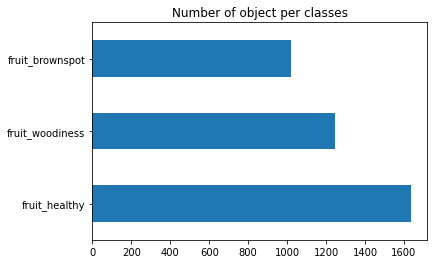

In [11]:
train_df["class"].value_counts().plot(kind = "barh")
plt.title("Number of object per classes")
plt.show()

In [12]:
train_df["Image_ID"].value_counts().describe()

count    3001.000000
mean        1.301566
std         0.621311
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: Image_ID, dtype: float64

In [13]:
print("Number of object per image on average: ", str(train_df["Image_ID"].value_counts().mean()) )

Number of object per image on average:  1.3015661446184605


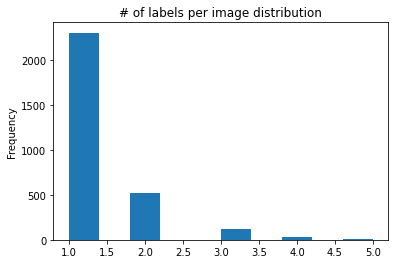

In [14]:
train_df["Image_ID"].value_counts().plot(kind = "hist")
plt.title("# of labels per image distribution")
plt.show()

## Data prep

### Train/test split

In [15]:
# train test split based on image_id

image_ids = train_df['Image_ID'].unique()
valid_ids = image_ids[-600:]
train_ids = image_ids[:-600]

valid_df = train_df[train_df['Image_ID'].isin(valid_ids)]
train_df = train_df[train_df['Image_ID'].isin(train_ids)]

valid_df.shape, train_df.shape

((774, 7), (3132, 7))

In [16]:
print("Number of image in train dataset: ", str((len(train_df["Image_ID"].unique()))))
print("Number of image in valid dataset: ", str((len(valid_df["Image_ID"].unique()))))

Number of image in train dataset:  2401
Number of image in valid dataset:  600


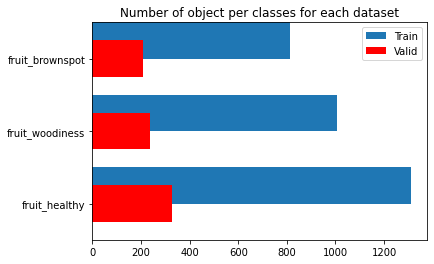

In [17]:
train_df["class"].value_counts().plot(kind = "barh", label = "Train" , align='edge')
valid_df["class"].value_counts().plot(kind = "barh", label = "Valid", color = "red")
plt.title("Number of object per classes for each dataset")
plt.legend()
plt.show()

# Model

In [18]:
class FruitDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['Image_ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['Image_ID'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        
        # there 3 classes
        labels = torch.tensor(records["integer_label"].values, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [19]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomBrightnessContrast(p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [20]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [21]:
num_classes = 4  # 3 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = FruitDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = FruitDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [24]:
# for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for TPU
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

## Sample image 

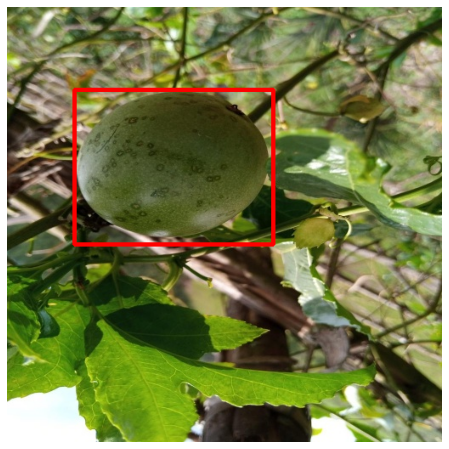

In [25]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

plt.show()

# Training

In [26]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None



In [27]:
def ckpt_save(val_list, loss, path):
    if len(val_list) == 0:
        torch.save(model,path )
        return print("Best model with loss: " + str(loss) + ", saving model to " + path)
    else:
        if loss < np.min(val_list):
            torch.save(model,path )
            return print("Best model with loss: " + str(loss) + ", saving model to " + path)

In [28]:
loss_hist = Averager()
train_loss = []
valid_loss = []
ckpt_path = "model_ckpt.pth"
itr = 1
num_epochs = 200
c = 0
patience = 5

for epoch in range(num_epochs):
    loss_hist.reset()
    
    time_start = time.clock()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        
    tl = loss_hist.value
    train_loss.append(loss_hist.value)
    #print(f"Epoch #{epoch} train loss: {loss_hist.value}") 
    
    loss_hist.reset()
    
    for images, targets, image_ids in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        
    valid_loss.append(loss_hist.value)
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    vl = loss_hist.value
    
    time_elapsed = int(time.clock() - time_start)
    
    print(f"Epoch #{epoch} {time_elapsed}s , train loss: {tl}, valid loss: {vl}, ")   
    
     # checking if last valid loss is the lowest, if yes, save it as checkpoint    
    if len(valid_loss) == 1:
        print("Best model with loss: " + str(loss_hist.value) + ", saving model to " + ckpt_path)
        torch.save(model,ckpt_path )        
    else:
        if valid_loss[-1] == np.min(valid_loss):
            print("Best model with loss: " + str(loss_hist.value) + ", saving model to " + ckpt_path)
            torch.save(model,ckpt_path )
            
    if valid_loss[-1] == np.min(valid_loss):
        c = 0
    else:
        c+=1
    
    if c == patience:
        print("Early stopping")
        break
            
        

Epoch #0 395s , train loss: 0.19564736858687368, valid loss: 0.10084270652060119, 
Best model with loss: 0.10084270652060119, saving model to model_ckpt.pth
Epoch #1 393s , train loss: 0.09005220625666768, valid loss: 0.080202835032215, 
Best model with loss: 0.080202835032215, saving model to model_ckpt.pth
Epoch #2 392s , train loss: 0.07251770190525263, valid loss: 0.07172020536636983, 
Best model with loss: 0.07172020536636983, saving model to model_ckpt.pth
Epoch #3 394s , train loss: 0.06473989657193123, valid loss: 0.0641870378552617, 
Best model with loss: 0.0641870378552617, saving model to model_ckpt.pth
Epoch #4 394s , train loss: 0.059329294296362925, valid loss: 0.06544502015485121, 
Epoch #5 394s , train loss: 0.05589415071976635, valid loss: 0.06028572698197057, 
Best model with loss: 0.06028572698197057, saving model to model_ckpt.pth
Epoch #6 394s , train loss: 0.05287589441807045, valid loss: 0.06300368746633894, 
Epoch #7 394s , train loss: 0.05214425297456441, valid

In [29]:
model = torch.load('model_ckpt.pth')

## training history

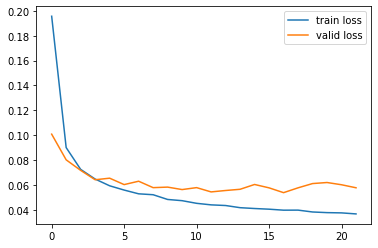

In [30]:
plt.plot(train_loss, label = "train loss")
plt.plot(valid_loss, label = "valid loss")
plt.legend()
plt.show()

In [31]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

## Sample predictions on valid dataset

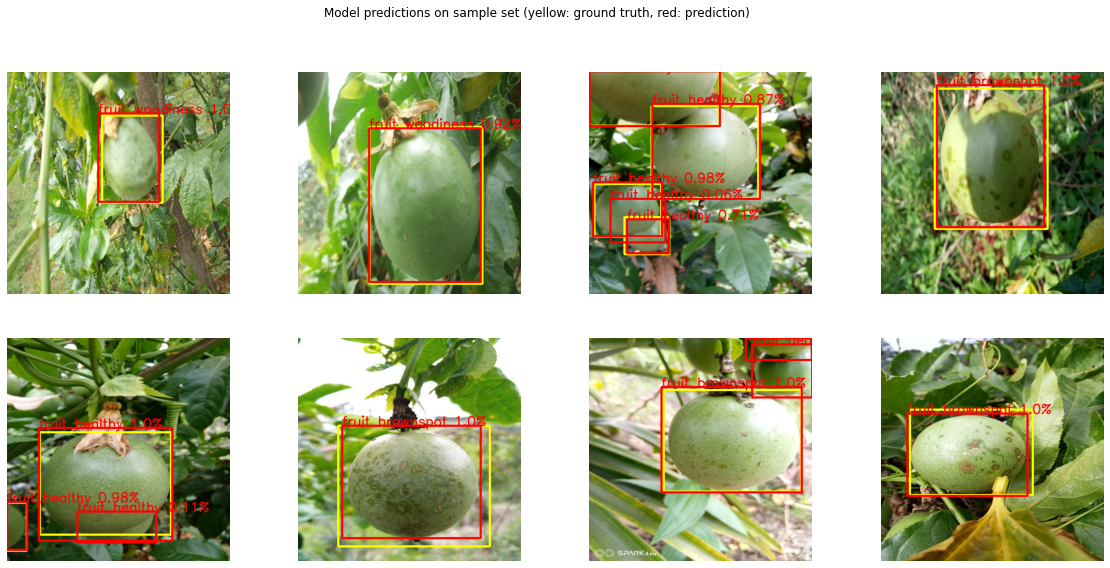

In [32]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

plt.figure(figsize=(20,9))

for i in range(len(image_ids)):
    plt.subplot(2,4,i+1)
    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    
    for gt_box in boxes:
        cv2.rectangle(sample,
                  (gt_box[0], gt_box[1]),
                  (gt_box[2], gt_box[3]),
                  (255, 255, 0), 3)
    
    scores = outputs[i]["scores"]
    pred_boxes = outputs[i]["boxes"]
    labels = outputs[i]["labels"]
    
    idx = nms(boxes = pred_boxes, scores = scores, iou_threshold=0.5)
    
    scores = outputs[i]["scores"][idx]
    pred_boxes = outputs[i]["boxes"][idx]
    labels = outputs[i]["labels"][idx]
    
       
    for score ,label, pred_box in zip(scores,labels,pred_boxes ):
        
        label = label.detach().numpy().astype(np.int32)


        pred_box = pred_box.detach().numpy().astype(np.int32)

        score = score.detach().numpy()
        
        
        cv2.rectangle(sample,
                  (pred_box[0], pred_box[1]),
                  (pred_box[2], pred_box[3]),
                  (220, 0, 0), 3)
        text = category_index[int(label)]["name"] +" " + str(round(float(score),2)) + "%"
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX

        # org
        org = (pred_box[0], pred_box[1])

        # fontScale
        fontScale = 1

        # Red color in BGR
        color = (220, 0, 0)

        # Line thickness of 2 px
        thickness = 2

        # Using cv2.putText() method
        image = cv2.putText(sample, text, org, font, fontScale, 
                         color, thickness, cv2.LINE_AA, False)
        
        
    

    plt.axis("off")
    plt.imshow(sample)
    
_ = plt.suptitle("Model predictions on sample set (yellow: ground truth, red: prediction)")

## Results dataframe

In [33]:
results_df = pd.DataFrame()

for images, targets, image_ids in valid_data_loader:
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model.eval()
    cpu_device = torch.device("cpu")

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    gt_df = pd.DataFrame(targets)

    for i in gt_df.index:

        gt_df["boxes"][i] = gt_df["boxes"][i].cpu().numpy().astype(np.int32)
        gt_df["labels"][i]  = gt_df["labels"][i].cpu().numpy()
    
    ids = []
    for i in image_ids:
        ids.append(i)

    gt_df["image_id"] = ids
    gt_df = gt_df[["image_id","boxes", "labels"]]
    
    pred_df = pd.DataFrame()

    pred_boxes_l = []
    pred_labels_l = []
    scores_l = []

    for i in range(len(image_ids)):
        scores = outputs[i]["scores"]
        pred_boxes = outputs[i]["boxes"]
        labels = outputs[i]["labels"]

        idx = nms(boxes = pred_boxes, scores = scores, iou_threshold=0.5)

        scores = outputs[i]["scores"][idx]
        pred_boxes = outputs[i]["boxes"][idx]
        labels = outputs[i]["labels"][idx]

        pred_boxes_l.append(pred_boxes)
        pred_labels_l.append(labels)
        scores_l.append(scores)


    pred_df["boxes"] = pred_boxes_l
    pred_df["labels"] = pred_labels_l
    pred_df["scores"] = scores_l

    pred_df.columns = ["pred_boxes","pred_labels","scores"]

    for i in pred_df.index:
        pred_df["scores"][i] = pred_df["scores"][i].detach().numpy()
        pred_df["pred_boxes"][i] = pred_df["pred_boxes"][i].detach().numpy().astype(np.int32)
        pred_df["pred_labels"][i]  = pred_df["pred_labels"][i].detach().numpy()

    
    temp_df = pd.concat([gt_df, pred_df], axis = 1)
    
    results_df = pd.concat([results_df, temp_df], axis = 0)
    
results_df.reset_index(inplace = True, drop = True)
results_df.head(20)

,image_id,boxes,labels,pred_boxes,pred_labels,scores
0,ID_SQRAUXYF,"[[218, 102, 357, 302]]",[2],"[[209, 97, 349, 300]]",[2],[0.9977246]
1,ID_SQUFHAYL,"[[164, 128, 423, 488]]",[2],"[[163, 131, 419, 484]]",[2],[0.92272234]
2,ID_SSKX0JYU,"[[0, 0, 299, 125], [143, 80, 388, 291], [12, 2...","[1, 1, 1, 1]","[[1, 0, 300, 126], [9, 255, 167, 379], [145, 7...","[1, 1, 1, 1, 1]","[0.9869868, 0.98372364, 0.8653751, 0.70879817,..."
3,ID_ST48UCPB,"[[123, 40, 382, 362]]",[3],"[[128, 32, 374, 358], [511, 17, 512, 24]]","[3, 1]","[0.99954295, 0.16041337]"
4,ID_STDTC11P,"[[75, 216, 376, 451], [0, 378, 45, 488]]","[1, 1]","[[73, 206, 379, 465], [0, 376, 46, 486], [161,...","[1, 1, 1]","[0.9980406, 0.9820224, 0.113138825]"
5,ID_STG91KAP,"[[92, 201, 440, 478]]",[3],"[[101, 201, 419, 459]]",[3],[0.9987991]
6,ID_SUFK0LXJ,"[[171, 119, 487, 352]]",[3],"[[166, 112, 488, 354], [374, 14, 512, 136], [3...","[3, 1, 3]","[0.99860305, 0.67211664, 0.1713738]"
7,ID_SUT4TJYW,"[[66, 164, 348, 360]]",[3],"[[60, 173, 336, 362]]",[3],[0.9962469]
8,ID_SUUDCJ32,"[[96, 167, 359, 393]]",[1],"[[95, 173, 362, 391]]",[1],[0.9888615]
9,ID_SV2FBE1B,"[[109, 251, 393, 447]]",[2],"[[111, 251, 381, 446], [511, 372, 512, 381], [...","[2, 1, 1]","[0.99698013, 0.16041337, 0.16041337]"


In [34]:
data = pd.DataFrame()

# looping through image_id to match best pred on gt 
for img in results_df["image_id"].unique():



    temp = results_df[results_df["image_id"]== img]
    image_id = temp["image_id"]
    boxes = [item for sublist in temp["boxes"] for item in sublist] 
    pred_boxes = [item for sublist in temp["pred_boxes"] for item in sublist] 

    labels = [item for sublist in temp["labels"] for item in sublist] 
    pred_labels = [item for sublist in temp["pred_labels"] for item in sublist] 

    scores = [item for sublist in temp["scores"] for item in sublist] 


    boxes_l = []
    labels_l = []
    pred_boxes_l = []
    pred_labels_l = []
    scores_l = []
    for box, label in zip(boxes, labels):
        if len(pred_boxes) == 0:
          
            boxes_l.append(box)
            labels_l.append(label)
            pred_boxes_l.append(np.array([1,1,1,1]))
            pred_labels_l.append([0])
            scores_l.append([0])
        else:
            for pred_box, pred_label, score in zip(pred_boxes, pred_labels, scores):
                boxes_l.append(box)
                labels_l.append(label)
                pred_boxes_l.append(pred_box)
                pred_labels_l.append(pred_label)
                scores_l.append(score)



    matchs = pd.DataFrame()

    matchs["boxes"] = boxes_l
    matchs["labels"] = labels_l

    matchs["pred_boxes"] = pred_boxes_l
    matchs["pred_labels"] = pred_labels_l

    matchs["scores"] = scores_l
    
    iou = []
    for i in matchs.index:
        iou.append(intersection_over_union(matchs["boxes"][i], matchs["pred_boxes"][i]))

    matchs["iou"] = iou
    
    matchs["image_id"] = image_id.values[0]
    
    matchs = matchs.sort_values("iou", ascending = False)
    
    if len(pred_boxes)> len(boxes):
        matchs = matchs.drop_duplicates(subset = "scores", keep = "first")

    if len(pred_boxes)< len(boxes):
        matchs.loc[matchs["iou"]<0.5, "pred_labels"] = 0
        
    matchs = matchs[matchs["iou"] > 0.5]
    data = pd.concat([data, matchs], axis = 0)

data.reset_index(inplace = True, drop = True)    
data

,boxes,labels,pred_boxes,pred_labels,scores,iou,image_id
0,"[218, 102, 357, 302]",2,"[209, 97, 349, 300]",2,0.997725,[0.8565484446205671],ID_SQRAUXYF
1,"[164, 128, 423, 488]",2,"[163, 131, 419, 484]",2,0.922722,[0.9617706452405629],ID_SQUFHAYL
2,"[0, 0, 299, 125]",1,"[1, 0, 300, 126]",1,0.986987,[0.9854758062382604],ID_SSKX0JYU
3,"[143, 80, 388, 291]",1,"[145, 75, 392, 293]",1,0.865375,[0.9448109383061842],ID_SSKX0JYU
4,"[12, 259, 165, 380]",1,"[9, 255, 167, 379]",1,0.983724,[0.929855659660674],ID_SSKX0JYU
...,...,...,...,...,...,...,...
767,"[96, 175, 385, 397]",1,"[97, 172, 384, 398]",1,0.999117,[0.9756224542921018],ID_ZZAB1FH1
768,"[330, 241, 512, 421]",1,"[316, 234, 509, 426]",1,0.996729,[0.8570060644749444],ID_ZZAB1FH1
769,"[98, 135, 374, 348]",1,"[96, 134, 375, 349]",1,0.999054,[0.9800450112528133],ID_ZZJZ2CV6
770,"[358, 234, 492, 341]",1,"[354, 232, 494, 341]",1,0.991230,[0.9395806028833555],ID_ZZJZ2CV6


# Scoring
## ROC

In [35]:
data["pred_labels"] = data["pred_labels"].astype("int")

y_test = label_binarize(data["labels"], classes=[1, 2,3])
y_score = label_binarize(data["pred_labels"], classes=[1, 2,3])
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

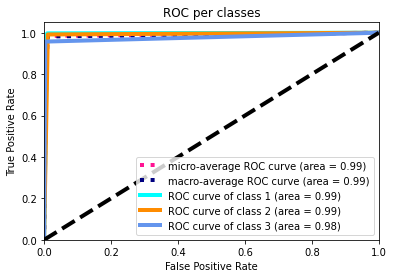

In [36]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

lw = 4

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC per classes")
plt.legend(loc="lower right")
plt.show()

## mAP @ 0.5

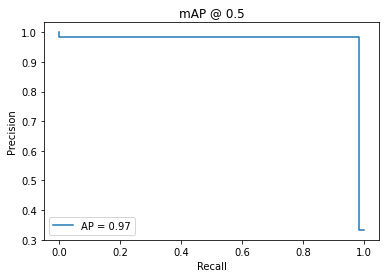

In [37]:


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("mAP @ 0.5")

In [38]:
torch.save(model, 'model.pth')